# Election simulation

the motivation of this notebook is to explore how the recent change in electoral system inThailand influences the outcome of an election, how it forge or destabilize party coalitions, and how one might counter-measure the change.
We will use an up-coming election in Thailand and historical data as our source material. 

The second motivation is for me to explore object-oriented coding in Python, which is something I learned a while ago in undergrad, but never really implemented it after.

## Historical Background

### recent history of Thailand
Thailand (my country of origin) has been through tough period of unstable politics. After a coup in 2006 overthrowing a powerful prime minister, Thaksin Shinawatra, the country has since changed 6 prime ministers and 4 constitutions.

The full analysis of this crisis is too detail to cover here, but one important factor is regionalism. The coalition of reformist, populist parties hold a stronghold in North and Northeast provinces; the more conservative Democratic party hold the Southern provinces as well as the capital; and the Central provinces are divided.

### the will of the majority
Since 2005 Thailand has 5 elections. The results are consistent that the populist party (or its successor and allies) won plurality of votes. Only once in 2005 that one party won absolute majority. Moreover, the support skews based on regions. After 2 military coups in 2006 and 2014, a new constitution is drafted to curtail the power of the populist party through adjusting how representatives are allocated.
The comparison of two constitutions is the focus of our study here.

### For American readers
There has been dicussions about whether to change and how to change the electoral college system. I hope that this analysis will give American readers some ideas of what simple election options there are to replace the electotal college. Note that we will only explore two main systems that exploy one round of votes, no runoff, no ranking, first-pass-the-post, and proportional system. there are still a lot more that we will not go through here.

## Electoral System

We will consider two methods that are used in recent Thai election; as well as look at vote-thresholding and two methods of rounding. The threshold doesn't really play important role for our Thailand election case.

### two-tier party list
Most readers may not be familiar with the party list representation. Essentially, members of Parlianment (MPs) are grouped into two: voting-district winners and elected party-list members. Let's say a country is divided into 400 voting districts, we will have 400 MPs. Additional 100 parliamentarian seats, called party list, are given to a party based on the number of nation-wide popular votes. One way to allocate party list is to make it **proportional** to the whole nation-wide popular votes. In our example, suppost 300 districts are won by party A, and 100 districts are won by party B. A gets additional 75 seats as party lists, and B gets 25 seats.


### mixed member apportionment
Similar to the two-tier party list system, constituents choose district representatives. Nation-wide votes are counted to determine how many total representatives each party will be allocated; let's call this number the apportioning seats. **The additional party list MPs will be added (if at all) to the district representatives to make the total MPs of a given party equals the apportioning seats.**
This creates a funny situation when a party wins more districts than the apportioning seats are given to them. This is called overhang seats. That party will not get any more apportioning seats. 
Imagine, party A wins all districts by a very small margin for each district, A will gets all all district representatives, but it's unlikely that A will get a party list.

This way of allocating seats give a small party (often single-issued party) a chance to be represented, because even if it doesn't win any district, it might be awarded party list. However, it punishes a big party, by not awarding any additional seats in case of overhang.

*The overhang seats will be important later on when we see the situation in Thailand.*



### threshold
a minimum share of the country-wide votes that a party must gain before they are entitled to any party list.

### Method of rounding
Often when a party list is allocated to parties, the exact proportionality is not possible one has to round the proportional seats often a fractional number to a whole number. The question is to round up or round down, and how to keep the total seats after rounding under the desired number. There are numbers of methods. But we will consider two methods:
#### Jefferson method (Highest average method)
Named after Thomas Jefferson who introduced this method to allocate the congressional seats to states in 1791, this method first allocates seats to the whole number of proportional seats disregard the remainders (decimal points). If there is any remaining seats, they are allocated first to highest remainders, and so on.

#### Webster method (Highest quotient method)
Named after Daniel Webster who proposed this method for 1840 to replace the  Jefferson method. In this method, sccuessive quotients are calculated for each party, the party that has the highest quotients gets the seat allocated.
Q = V/(2s+1) : Q = quotients, V = total votes of a party, s = number of seats that has been allocated to the party so far, initially set at 0.
The quotient is recalculated and the process is repeated until all seats have been allocated.

*Thailand election use Jefferson rounding method. But I encourage readers to explore Webster method as well.
Here is one case where the two methods will assign different seats:
we have 7 seats to give to 3 parties (A,B, and C).
party A has 53000 votes
party B has 24000 votes
party C has 2300 votes
Readers can try to work out how many seatss each party will get from Jefferson rounding, or Webster rounding; and maybe the bigger question is, which one is fairer?
*

In [39]:
# Invoking Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%config InlineBackend.figure_format = 'retina'
import warnings
%matplotlib inline

# Object Oriented Codes

In [40]:
class PL_1997(object):
    """will call child class to take in the election information and provide a method for the child class to calculate the party-list
    proportional representation according to Thailand Constitution of 1997. It is also used in the 2011 election. 
    The rounding use Jefferson Method
    This will be an abstract class, that is, it will not be instantiated directly. It also will not initialize anything. But it will take in
    any information about the election from the child class."""
    

    def count_1997_party_list(self):
        
        party_list_num = self.get_party_list_num()  #get number of party list seats total
        
        """Use Jefferson method for distributing seats"""
        list_party_above_threshold = self.find_party_above_threshold()  # get a list of parties names whose nation-wide popular votes is above threshold 
        corrected_voter_per_rep = self.get_voter_per_rep_with_threshold() #get no. of voters per representatives. 
        vote_per_party = self.count_total_vote_per_party()  #get nation-wide votes for every party.
        list_of_list = [[],[],[]]
        for name in list_party_above_threshold:  #we will separate integer and decimal
            list_of_list[0].append(name)
            list_of_list[1].append(int(vote_per_party[name]/corrected_voter_per_rep))
            list_of_list[2].append((vote_per_party[name]/corrected_voter_per_rep) - int(vote_per_party[name]/corrected_voter_per_rep))

        df = pd.DataFrame(list_of_list).T
        df = df.rename(columns={0:'name',1:'whole',2:'decimal'})
        df = df.sort_values(by=['decimal'], ascending=False)  #rank party by decimal
        
        partylist_per_party = dict((el,0) for el in self.get_party_name())
        counter = party_list_num - df['whole'].sum()
        
        for i in  df['name']:
            partylist_per_party[str(i)] += int(df['whole'][df['name'] == i])
            if counter > 0:   #if we have seats left we will award the remaining seats by looking at the rank of decimal (the closest one to the next integer is awarded)
                partylist_per_party[str(i)] += 1
                counter -= 1
        
        return partylist_per_party

In [41]:
class PL_Webster(object):
    """will call child class to take in the election information and provide a method for the child class to calculate 
    the party list using the Webster highest quotient method as the rounding method.
    The overhang seats are not accounted for. 
    This has not been adopted in Thailand constitution before.
    So they may be more or less total representatives; depending on how many overhangs are there. The threshold is 5%
    This will be an abstract class, that is, it will not be instantiated directly."""
    
            
    def count_Webster_party_list(self):
        """Use highest quotient method for distributing seats. 
        Return dictionary of party lists where keys are party name, and values are the number of party lists assigned"""
        
        party_list_num = self.get_party_list_num()  #get total number of party list from method of child class.
        
        list_party_above_threshold = self.find_party_above_threshold()  #get lists of party whose popular votes is above the threshold.
        corrected_voter_per_rep = self.get_voter_per_rep_with_threshold()  # get number of voters per representatives
        vote_per_party = self.count_total_vote_per_party()  # get how many nation-wide votes every party will get.
        
        #here is the rounding steps
        list_of_list = [[],[],[]]
        for name in list_party_above_threshold:
            list_of_list[0].append(name)
            list_of_list[1].append(int(vote_per_party[name]))
            list_of_list[2].append(0)
        
        df = pd.DataFrame(list_of_list).T
        df = df.rename(columns={0:'name',1:'votes',2:'seat'})
        df = df.sort_values(by=['votes'], ascending=False)
      
        while df['seat'].sum() < party_list_num:  #keep adding seats one by one until the number = party_list_num
            df['quotients'] = pd.to_numeric(df['votes']/(2*df['seat'] + 1))
            df['seat'] = np.where(df.index == df.quotients.idxmax(axis=0), df['seat'] + 1, df['seat'])    #pick one that has highest quotient and award one seat for that.
        
        partylist_per_party = dict((el,0) for el in self.get_party_name())
        
        for i in  df['name']:
            partylist_per_party[str(i)] += int(df['seat'][df['name'] == i])  
        return partylist_per_party

In [42]:
class MMA(object):
    """will call child class to take in the election information and provide a method for the child class to calculate 
    the Mixed majority Apportionment system which is a style used by Thai election of 2019. 
    The rounding use Jefferson method; and if after the rounding the total numbers of seats exceed the desired number of seats,
    another round of normalization is performed.
    The overhang seats are kept but is subtracted from the apportioning seats. 
    So they may be more or less total representatives; depending on how many overhangs are there. The threshold is 5%
    This will be an abstract class, that is, it will not be instantiated directly."""
    
    def MMA_get_voter_per_rep_with_threshold(self):
        list_party_above_threshold = self.find_party_above_threshold()
        vote_per_party = self.count_total_vote_per_party()
        voter_above_threshold = 0
        for i in list_party_above_threshold:
            voter_above_threshold += vote_per_party[i]
        return voter_above_threshold/(self.party_list_num + len(self.get_district_table()))
    
    def count_MMA_party_list(self):
        warnings.filterwarnings('ignore')
        district_winner_dict = self.count_district_winner()
        corrected_voter_per_total_rep = self.MMA_get_voter_per_rep_with_threshold()
        vote_per_party = self.count_total_vote_per_party()
        party_list_num = self.get_party_list_num()
        list_party_above_threshold = self.find_party_above_threshold()
    
        list_of_list = [[],[],[],[]]
        for name in list_party_above_threshold:
            uncorrected_expected_party_list = max((vote_per_party[name]/corrected_voter_per_total_rep) - 
                                                  district_winner_dict[name],0)
            list_of_list[0].append(name)
            list_of_list[1].append(int(uncorrected_expected_party_list))
            list_of_list[2].append(uncorrected_expected_party_list - int(uncorrected_expected_party_list))
            list_of_list[3].append(uncorrected_expected_party_list)

        df = pd.DataFrame(list_of_list).T
        df = df.rename(columns={0:'name',1:'whole',2:'decimal',3:'uncorrected_expected_party_list'})
        df = df.sort_values(by=['decimal'], ascending=False)
        
        partylist_per_party = dict((el,0) for el in self.get_party_name())
        counter = party_list_num - df['whole'].sum()
        
        for i in  df['name']:
            partylist_per_party[str(i)] += int(df['whole'][df['name'] == i])
            if counter > 0:
                partylist_per_party[str(i)] += 1
                counter -= 1
        
        df["1st_round_party_list"] = 0
        for i in partylist_per_party:
            df['1st_round_party_list'][df['name'] == i] = partylist_per_party[i]

        if sum(partylist_per_party.values()) > party_list_num:
            #print('second rounding step')
          #  print(df)
            df['2nd_round_party_list'] = 1

            for i in range(len(list_party_above_threshold)):
                if df["1st_round_party_list"][i] == 0:
                    df['2nd_round_party_list'][i] = 0

                else:
                    df['2nd_round_party_list'][i] = df['uncorrected_expected_party_list'][i]*party_list_num/sum(partylist_per_party.values())

            df['whole_2ndround'] = df['2nd_round_party_list'].as_matrix().astype(int)
            df['decimal_2ndround'] = df['2nd_round_party_list'] - df['whole_2ndround']
            df = df.sort_values(by=['decimal_2ndround'], ascending=False)
            

            normalized_partylist_per_party = dict((el,0) for el in self.get_party_name())
            counter = party_list_num - df['whole_2ndround'].sum()
        
            for i in  df['name']:
                normalized_partylist_per_party[str(i)] += int(df['whole_2ndround'][df['name'] == i])
                if counter > 0:
                    normalized_partylist_per_party[str(i)] += 1
                    counter -= 1
            return normalized_partylist_per_party
        return partylist_per_party

In [43]:
class Election_simulation(PL_1997,PL_Webster,MMA):
    """child class of PL_1997, PL_Webster and MMA abstract classes. Will inherit the methods from parent classes."""
    
    #run_simulation = 0
    
    def __init__(self,district_table,weight):
        PL_1997.__init__(self)
        PL_Webster.__init__(self)
        MMA.__init__(self)
        self.district_table = district_table
        self.weight = weight
        self.voter_per_district = 189000
        self.run_simulation = 0
        self.party_list_num = 100
        self.threshold = 0.05
    
    def simulate_vote(self):
        """   This function simulates the voting in the election day. it will fill in how many people vote for each party 
        in each district. The voting is simulated by using multinomial distribution of vote result for people in the district."""
        ind = 1
        if len(self.weight) == 1:
            for row in self.district_table.index:
                self.district_table.loc[row] = np.random.multinomial(self.voter_per_district, self.weight[ind], size=1)
        else:
            for row in self.district_table.index:
                self.district_table.loc[row] = np.random.multinomial(self.voter_per_district, self.weight[ind], size=1)
                ind += 1
        self.run_simulation = 1
        return self.district_table
    
    def get_district_table(self):
        return self.district_table
    
    def get_weight(self):
        return self.weight

    def count_district_winner(self):
        name = self.get_party_name()[1]
        if pd.isna(self.district_table[name][1]):
            raise NameError('The election has not been simulated. Please call function simulate_vote')
        
        if 'winner' not in self.district_table.columns.values:
            self.district_table['winner'] = self.district_table.idxmax(axis=1)
        
        district_rep = dict((el,0) for el in self.get_party_name())
        for i in district_rep:
            district_rep[i] = (self.district_table.winner == str(i)).sum()
        #print(str(district_rep) + '  as district representatives numbers')
        return district_rep
    
    def count_total_vote_per_party(self):
        vote_per_party = dict((el,0) for el in self.get_party_name())
        tuple_party_vote = []
        for i in vote_per_party:
            vote_per_party[i] = self.district_table[i].sum()
        return vote_per_party
    
    def count_total_vote(self):
        total_legit_vote = 0
        for i in self.get_party_name():
            total_legit_vote += self.district_table[i].sum()
        return total_legit_vote
    
    def set_threshold(self,threshold):
        self.threshold = threshold
    
    def set_party_list_num(self,party_list_num):
        self.party_list_num = party_list_num
    
    def get_threshold(self):
        return self.threshold
    
    def get_party_name(self):
        return sorted(list(set(self.get_district_table().columns.values) - {'winner'}))
    
    def get_party_list_num(self):
        return self.party_list_num
    
    def find_party_above_threshold(self):
        list_party_above_threshold = []
        vote_per_party = self.count_total_vote_per_party()
        total_vote = self.count_total_vote()
        for i in self.get_party_name():
            if vote_per_party[i]/total_vote > self.threshold:  #the default threshold level is 5%
                list_party_above_threshold.append(i)
        return list_party_above_threshold
    
    def get_voter_per_rep_with_threshold(self):
        list_party_above_threshold = self.find_party_above_threshold()
        vote_per_party = self.count_total_vote_per_party()
        voter_above_threshold = 0
        for i in list_party_above_threshold:
            voter_above_threshold += vote_per_party[i]
        return voter_above_threshold/self.party_list_num

# Helper function
We use this to generate the Pandas dataframe to keep tract of the votes in each districts. We also create a function that generates a dictionary of fractional weights representing voting fractions given to parties.

In [44]:
def generate_district_table(n=350):
    """generate n-row dataframe and 5 columns for each party.  """
    d = {}
    party_name = ['PT','Dem','FF','PP','misc']
    for name in party_name:
        d[name] = np.empty(n)
        d[name].fill(np.nan)
    df = pd.DataFrame(d,index=list(range(1,n+1)))
    df = df[['PT','Dem','FF','PP','misc']]
    return df

In [45]:
def generate_actual_weight():
    """generate a voting weights that resembles the voting pattern of Thailand in 2011 (most recent general election)."""
    temp_dict ={}
    #the order of party is PT,   Dem,   FF,  PP,  misc
    # 
    for i in range(1,60):  # Central provinces 1
        temp_dict[i] = [0.405,0.40,0.1,0.065,0.03]
    for i in range(60,85):  # Central provinces 2
        temp_dict[i] = [0.25,0.15,0.2,0.2,0.2]
    for i in range(85,115): # 12  central districts that vote randomly 1
        temp_dict[i] = [0.25,0.25,0.2,0.2,0.1]
    for i in range(115,132): # 12  central districts that vote randomly 2
        temp_dict[i] = [0.2,0.25,0.15,0.2,0.2]
    for i in range(132,180):  # South prvinces 1
        temp_dict[i] = [0.34,0.5,0.04,0.09,0.03]
    for i in range(180,255):  #  Northeastern provinces 1
        temp_dict[i] = [0.5,0.15,0.07,0.11,0.16]
    for i in range(255,270):  #  Northeastern provinces 2
        temp_dict[i] = [0.2,0.15,0.37,0.11,0.16]
    for i in range(270,290):  #  Northeastern provinces 3
        temp_dict[i] = [0.25,0.1,0.35,0.1,0.2]
    for i in range(290,306):  #  Northeastern provinces 4
        temp_dict[i] = [0.2,0.2,0.2,0.2,0.2]
    for i in range(306,356):  #  North provinces 1
        temp_dict[i] = [0.435,0.435,0.07,0.04,0.02]
    for i in range(356,376):  #  North provinces 2
        temp_dict[i] = [0.43,0.430,0.08,0.04,0.02]
    return temp_dict

In [46]:
election_2011 = Election_simulation(generate_district_table(375),generate_actual_weight())
election_2011.set_threshold(0.0)
election_2011.simulate_vote()
election_2011.set_party_list_num(125)

In [47]:
election_2011.get_party_name()

['Dem', 'FF', 'PP', 'PT', 'misc']

In [48]:
election_2011.count_1997_party_list()

{'Dem': 37, 'FF': 16, 'PP': 14, 'PT': 45, 'misc': 13}

## Simulation of the General Election in 2011

The party we will focus on are PT (Puer Thai) party which is the biggest party. I describe it as more rural-oriented, economically liberal, and has populist tendency.
The second party is Democratic party which is 2nd biggest party. It is more urban oritented, economically more conservative, and more align with the "old establishment" as opposed to the populism. The other smaller parties are more fluid, and they are looking to form coalition with either PT or Dem, depending on how many vote PT gets.

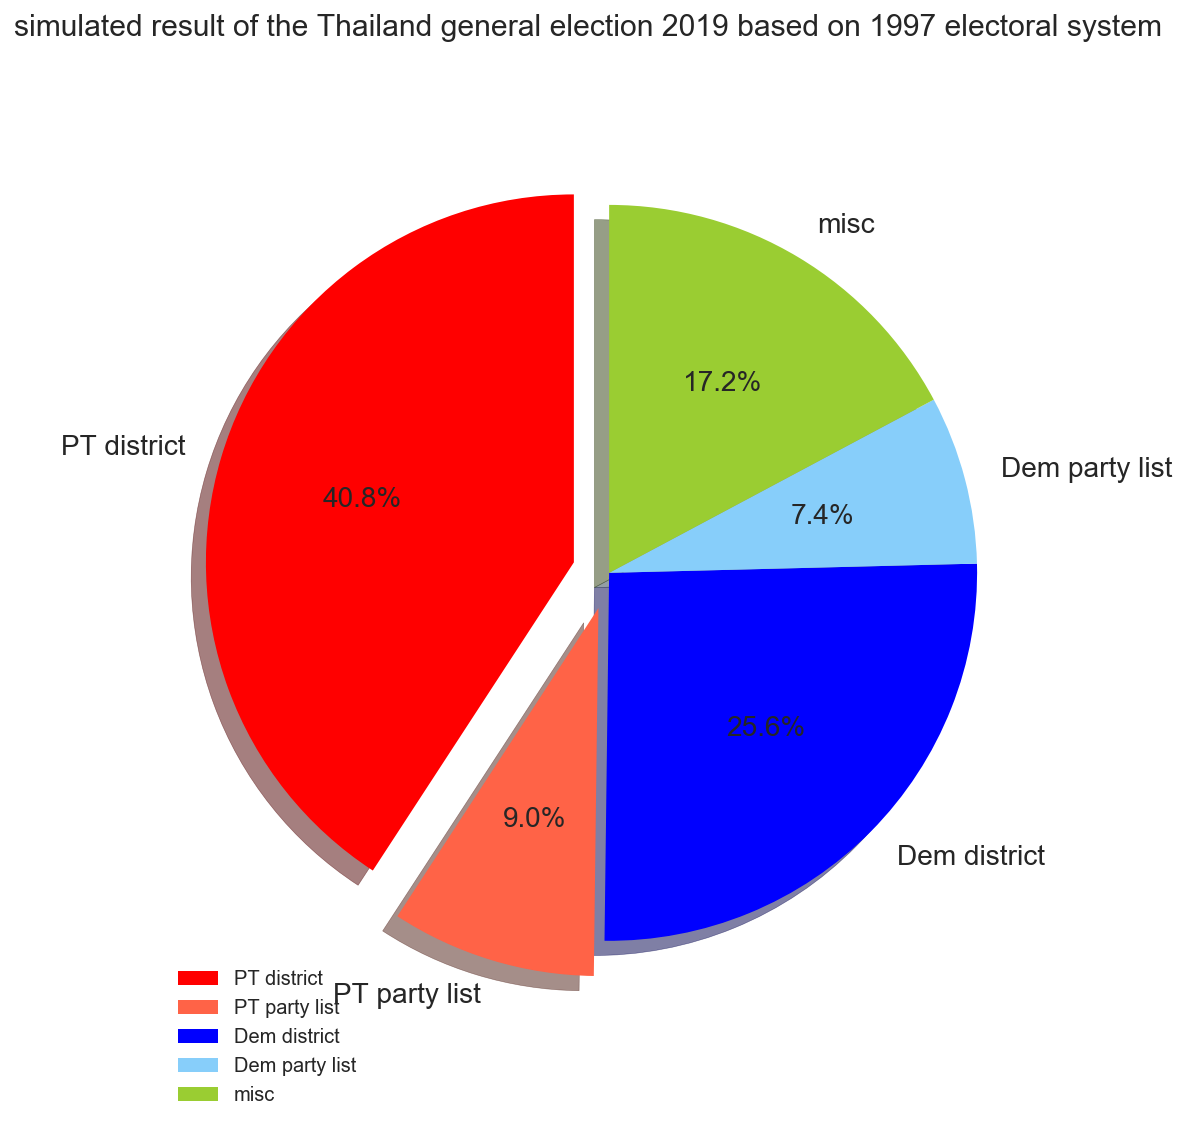

In [49]:
labels = ['PT district','PT party list','Dem district','Dem party list','misc']
list1 = [election_2011.count_district_winner()['PT'],election_2011.count_1997_party_list()['PT'],
         election_2011.count_district_winner()['Dem'],election_2011.count_1997_party_list()['Dem'],
         election_2011.count_district_winner()['PP'] +election_2011.count_1997_party_list()['PP']+
         election_2011.count_district_winner()['FF'] +election_2011.count_1997_party_list()['FF']+
         election_2011.count_district_winner()['misc']+election_2011.count_1997_party_list()['misc']]
#sizes =[sum(x) for x in zip(list1, list2)]
explode = (0.1, 0.1,0,0, 0)
colors = ['red','tomato', 'blue','lightskyblue','yellowgreen']
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(list1, explode=explode,colors = colors, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize': 14})
plt.legend(labels, loc="best", fontsize = 10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('simulated result of the Thailand general election 2019 based on 1997 electoral system', fontsize = 15)
plt.tight_layout()
#fig1.savefig('1997_constitution.png',bbox_inches = "tight")

## 2019 election prediction
We assume the voting trend remains the same. Thus we will use the same election simulation instant as in 2011 election. The only change is simply the new method of apportioning party list seats. We will see clearly that the big party is punished here. 

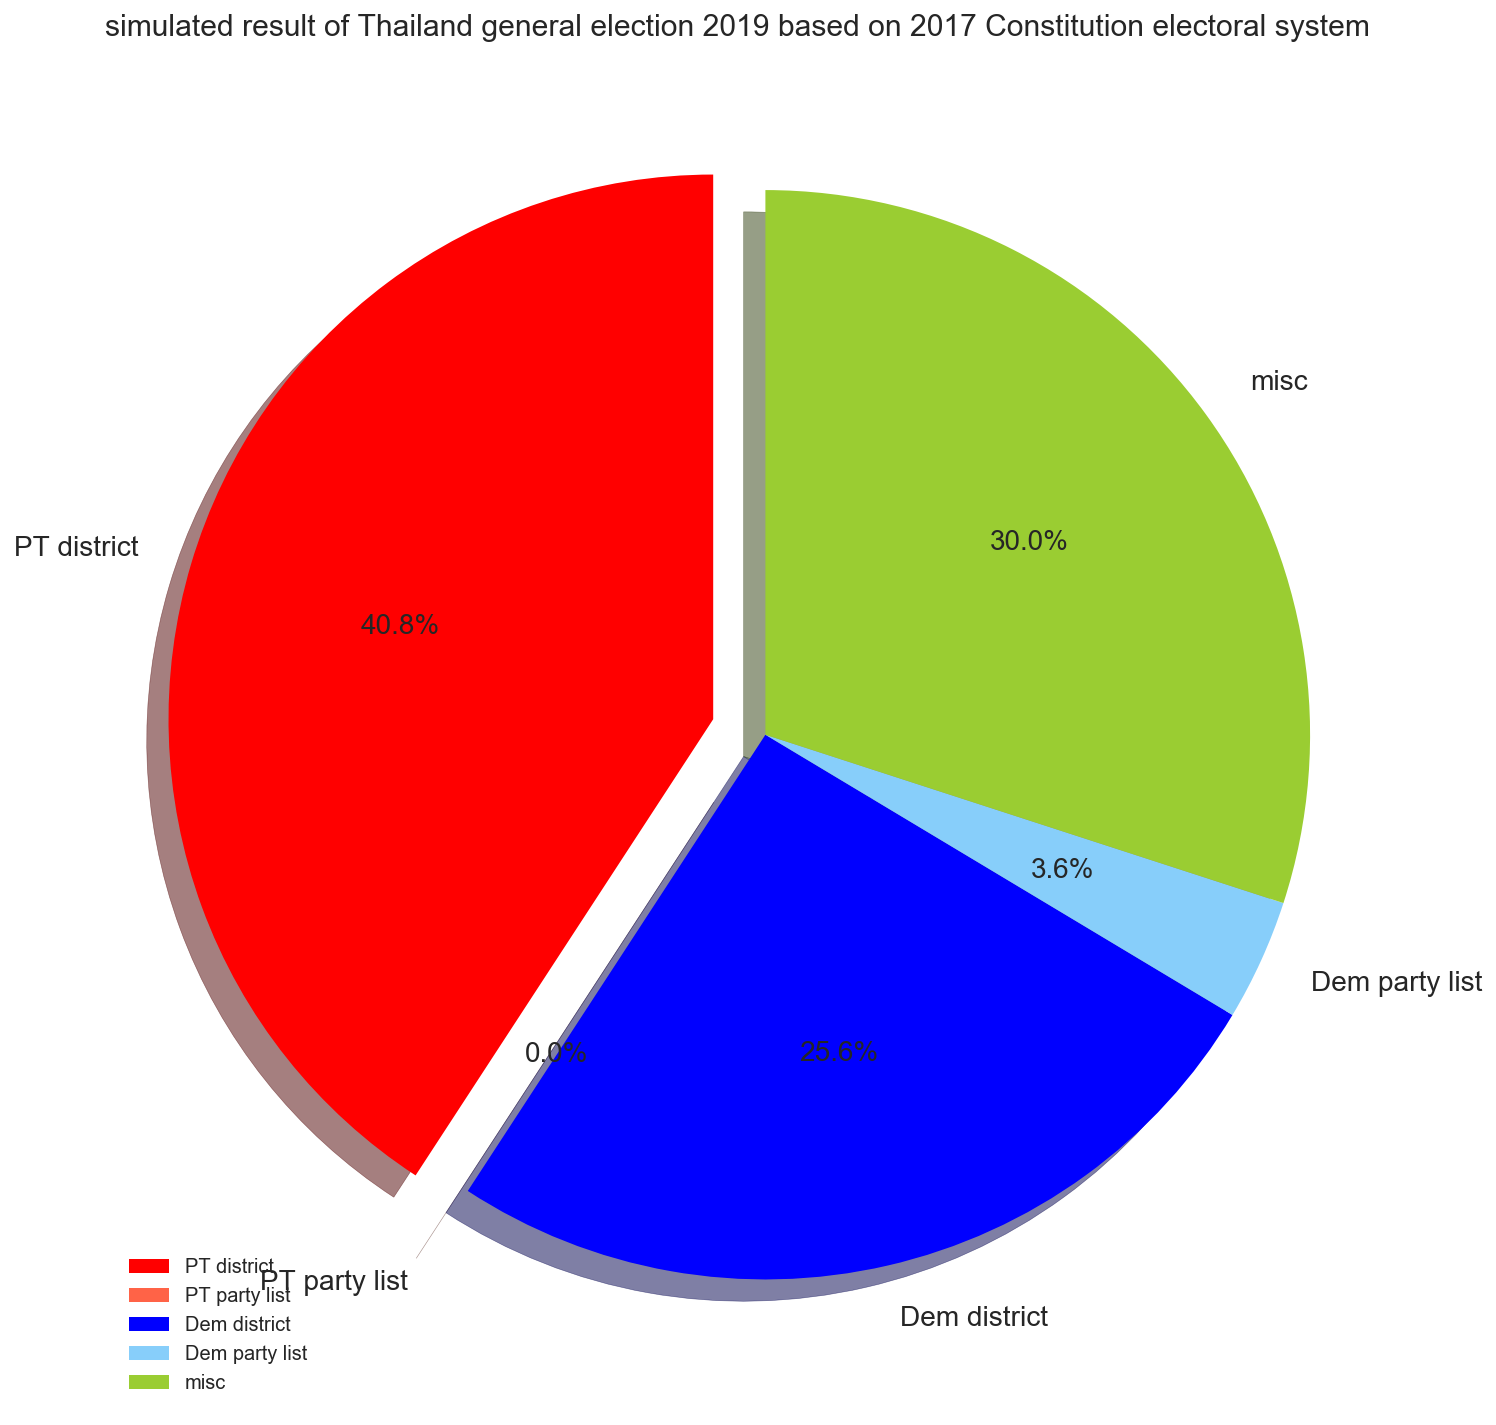

In [50]:
labels = ['PT district','PT party list','Dem district','Dem party list','misc']
list1 = [election_2011.count_district_winner()['PT'],election_2011.count_MMA_party_list()['PT'],
         election_2011.count_district_winner()['Dem'],election_2011.count_MMA_party_list()['Dem'],
         election_2011.count_district_winner()['PP'] +election_2011.count_MMA_party_list()['PP']+
         election_2011.count_district_winner()['FF'] +election_2011.count_MMA_party_list()['FF']+
         election_2011.count_district_winner()['misc']+election_2011.count_MMA_party_list()['misc']]
#sizes =[sum(x) for x in zip(list1, list2)]
explode = (0.1, 0.1,0,0, 0)
colors = ['red','tomato', 'blue','lightskyblue','yellowgreen']
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(list1, explode=explode,colors = colors, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize': 14})
plt.legend(labels, loc="best", fontsize = 10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('simulated result of Thailand general election 2019 based on 2017 Constitution electoral system', fontsize =15)
plt.tight_layout()
#fig1.savefig('2017_constitution.png',bbox_inches = "tight")

# The Overhang seat problem

## Observation

We see that the MMA system penalizes the big party. This is because the nation-wide votes of the party are accounted for by both the district representatives and the party lists. If the party wins a slight majority in many districts, the district seats may "soak up" the apportioning seats, and the party risks not gaining as many party lists as they would in other system. This is the overhang seat problem that I told earlier. In fact, in our example above, PT which is the biggest party does not get any party list seats at all in the MMA system, because PT has more overhang seats than the apportioning seats they are allowed to get. The result is that from the previous system set by 1997 Constitution PT can single-handedly form a government, now in this MMA system noone wins the majority.

## Countermeasure

A way to countermeasure this system is to create a branch party (or a nominee so to speak). From one big party we will have the main paty and the branch party. Let's see how this might work!
We will simulate the election assuming that the voting and all the districts does not change in the population. All that is change is that we have a branch party that runs in certain districts and not run in other districts.

In [51]:
def generate_countermeasure_district_table(n=350):
    """generate n-row dataframe and 6 columns for each party. 
    PT, which is the biggest party is now split into two parties that run on different sets of districts."""
    d = {}
    party_name = ['PT1','PT2','Dem','FF','PP','misc']
    for name in party_name:
        d[name] = np.empty(n)
        d[name].fill(np.nan)
    df = pd.DataFrame(d,index=list(range(1,n+1)))
    df = df[['PT1','PT2','Dem','FF','PP','misc']]
    return df

In [52]:
def generate_countermeasure_weight():
    """generate a voting weights that resembles the voting pattern of Thailand in 2011 (most recent general election)."""
    temp_dict ={}
    #the order of party is PT1, PT2,   Dem,   FF,  PP,  misc
    # 
    for i in range(1,30):  # Central provinces 1.1
        temp_dict[i] = [0.405,0, 0.40,0.1,0.065,0.03]
    for i in range(30,60):  # Central provinces 1.2
        temp_dict[i] = [0.405,0,0.40,0.1,0.065,0.03]
        
    for i in range(60,72):  # Central provinces 2.1
        temp_dict[i] = [0.22,0.03,0.15,0.2,0.2,0.2]
    for i in range(72,85):  # Central provinces 2.2
        temp_dict[i] = [0.22,0.03,0.15,0.2,0.2,0.2]
        
    for i in range(85,100): # 12  central districts that vote randomly 1.1
        temp_dict[i] = [0.25,0,0.25,0.2,0.2,0.1]
    for i in range(100,115): # 12  central districts that vote randomly 1.2
        temp_dict[i] = [0.25,0,0.25,0.2,0.2,0.1]
        
    for i in range(115,124): # 12  central districts that vote randomly 2.1
        temp_dict[i] = [0,0.2,0.25,0.15,0.2,0.2]
    for i in range(124,132): # 12  central districts that vote randomly 2.2
        temp_dict[i] = [0,0.2,0.25,0.15,0.2,0.2]
        
    for i in range(132,157):  # South prvinces 1.1
        temp_dict[i] = [0,0.34,0.5,0.04,0.09,0.03]
    for i in range(157,180):  # South prvinces 1.2
        temp_dict[i] = [0,0.34,0.5,0.04,0.09,0.03]

    for i in range(180,220):  #  Northeastern provinces 1.1
        temp_dict[i] = [0.23,0.22,0.15,0.07,0.11,0.16]
    for i in range(220,255):  #  Northeastern provinces 1.2
        temp_dict[i] = [0.23,0.22,0.15,0.07,0.11,0.16]

    for i in range(255,262):  #  Northeastern provinces 2.1
        temp_dict[i] = [0,0.2,0.15,0.37,0.11,0.16]
    for i in range(262,270):  #  Northeastern provinces 2.2
        temp_dict[i] = [0,0.2,0.15,0.37,0.11,0.16]
        
    for i in range(270,280):  #  Northeastern provinces 3.1
        temp_dict[i] = [0,0.25,0.1,0.35,0.1,0.2]
    for i in range(280,290):  #  Northeastern provinces 3.2
        temp_dict[i] = [0,0.25,0.1,0.35,0.1,0.2]

    for i in range(290,298):  #  Northeastern provinces 4.1
        temp_dict[i] = [0.2,0,0.2,0.2,0.2,0.2]
    for i in range(298,306):  #  Northeastern provinces 4.2
        temp_dict[i] = [0.2,0,0.2,0.2,0.2,0.2]

    for i in range(306,331):  #  North provinces 1.1
        temp_dict[i] = [0.435,0,0.435,0.07,0.04,0.02]
    for i in range(331,356):  #  North provinces 1.2
        temp_dict[i] = [0.435,0,0.435,0.07,0.04,0.02]

    for i in range(356,366):  #  North provinces 2.1
        temp_dict[i] = [0.43,0,0.430,0.08,0.04,0.02]
    for i in range(366,376):  #  North provinces 2.2
        temp_dict[i] = [0.43,0,0.430,0.08,0.04,0.02]
    return temp_dict

In [53]:
election_countermeasure = Election_simulation(generate_countermeasure_district_table(375),
                                              generate_countermeasure_weight())
election_countermeasure.set_threshold(0.0)
election_countermeasure.simulate_vote()
election_countermeasure.set_party_list_num(125)

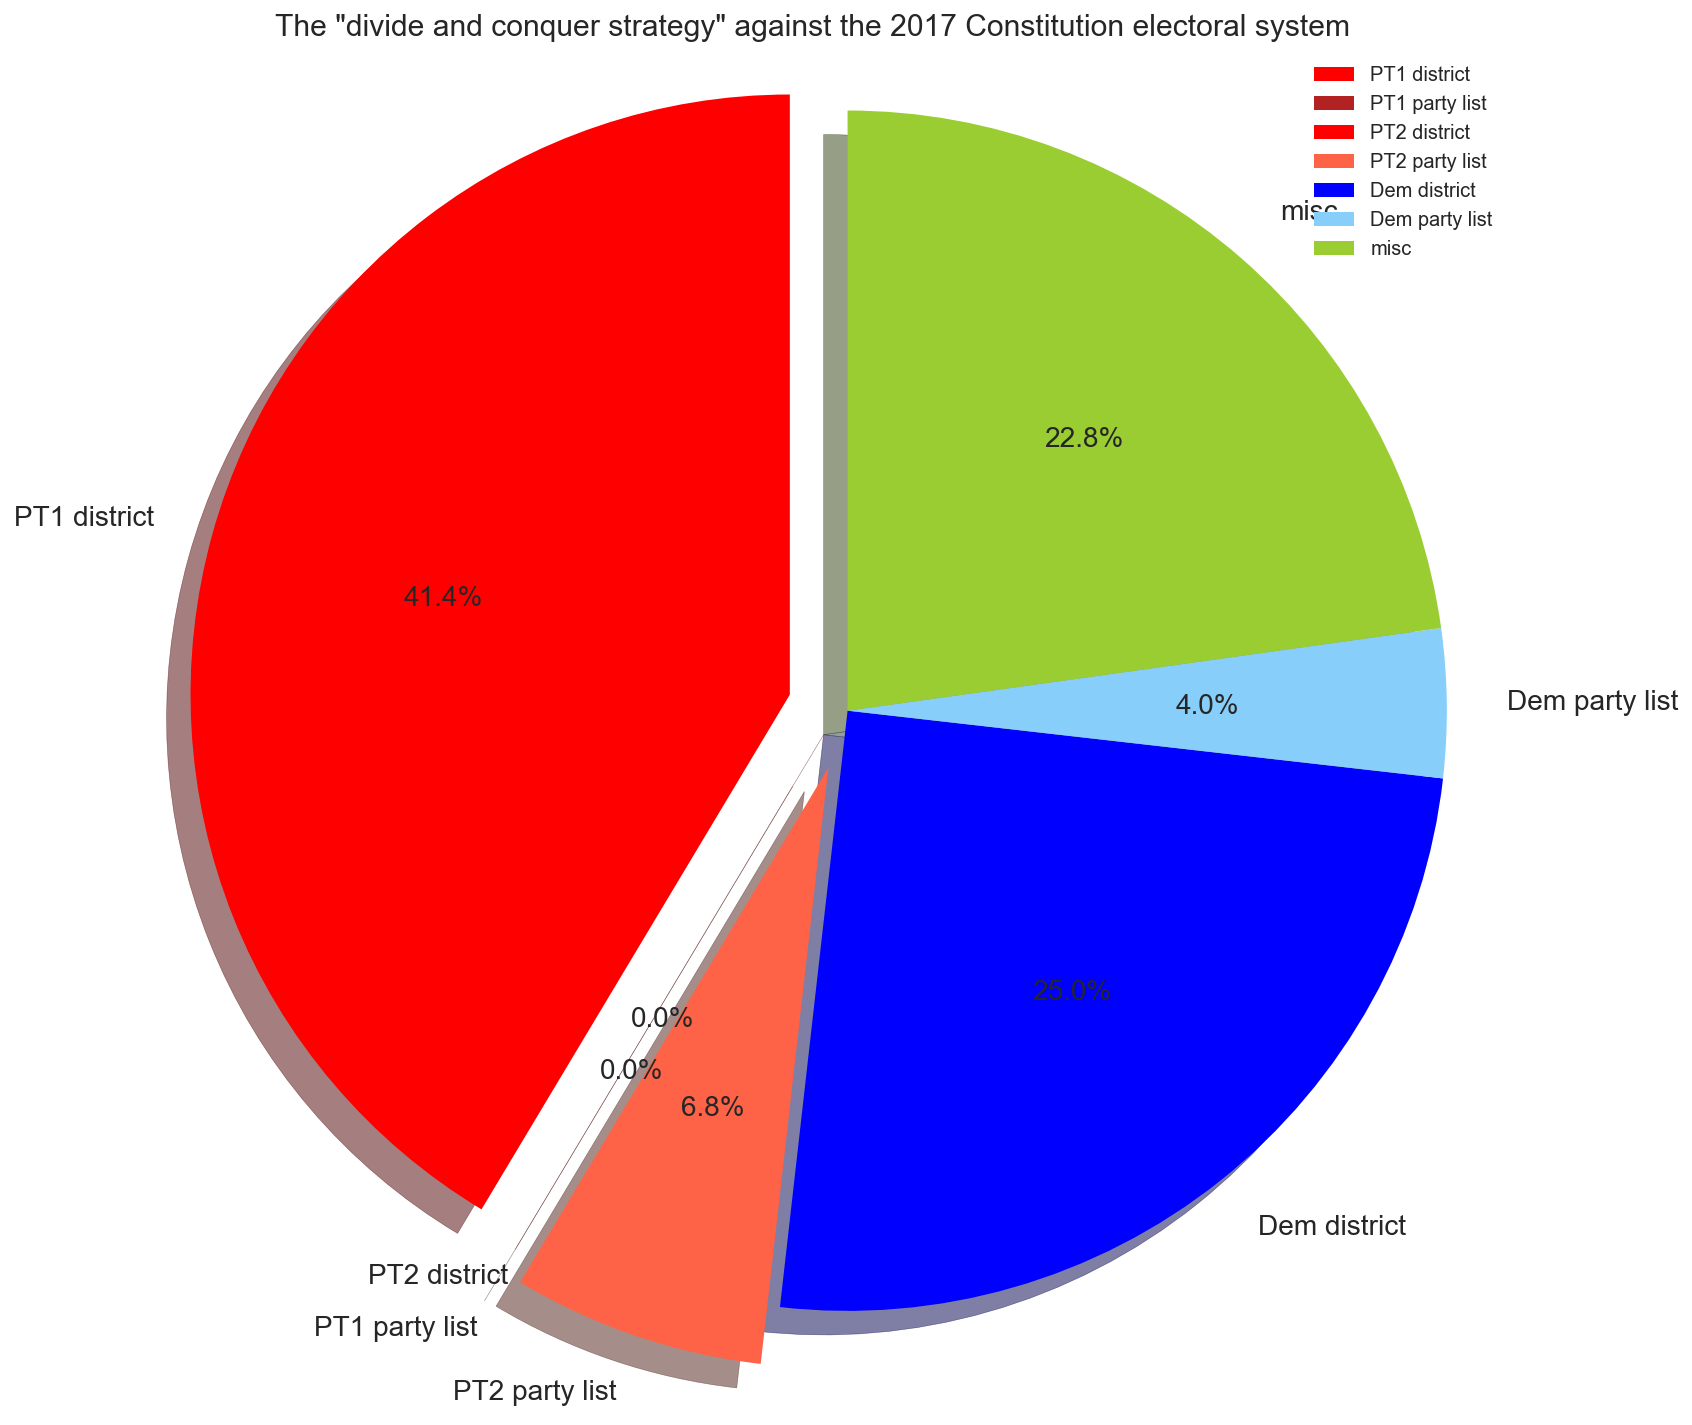

In [54]:
labels = ['PT1 district','PT1 party list','PT2 district','PT2 party list','Dem district','Dem party list','misc']
list1 = [election_countermeasure.count_district_winner()['PT1'],election_countermeasure2.count_MMA_party_list()['PT1'],
         election_countermeasure.count_district_winner()['PT2'],election_countermeasure2.count_MMA_party_list()['PT2'],
         election_countermeasure.count_district_winner()['Dem'],election_countermeasure2.count_MMA_party_list()['Dem'],
         election_countermeasure.count_district_winner()['PP'] +election_countermeasure2.count_MMA_party_list()['PP']+
         election_countermeasure.count_district_winner()['FF'] +election_countermeasure2.count_MMA_party_list()['FF']+
         election_countermeasure.count_district_winner()['misc']+election_countermeasure2.count_MMA_party_list()['misc']]
#sizes =[sum(x) for x in zip(list1, list2)]
explode = (0.1, 0.1,0, 0.1,0,0, 0)
colors = ['red','firebrick','r','tomato', 'blue','lightskyblue','yellowgreen']
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(list1, explode=explode,colors = colors, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90,  textprops={'fontsize': 14})
plt.legend(labels, loc="best", fontsize = 10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('The "divide and conquer strategy" against the 2017 Constitution electoral system',fontsize =15)
plt.tight_layout()
fig1.savefig('divide and conquer.png',bbox_inches = "tight")

# The secret of rearrangment

The funny thing that comes off of this analysis is that by sub-branching a party into a smaller party, the smaller party helps recover almost fully the loss imposed on it by to the change in the electoral system.

In [56]:
print('The party PT1 gets ...'+ str(election_countermeasure.count_district_winner()['PT1']) +'... district representatives')
print('The party PT1 gets ...'+ str(election_countermeasure.count_MMA_party_list()['PT1']) +'... party list')
print('The branch party PT2 gets ...'+ str(election_countermeasure.count_district_winner()['PT2']) +'... district representatives')
print('The branch party PT2 gets ...'+ str(election_countermeasure.count_MMA_party_list()['PT2']) +'... party list')

The party PT1 gets ...207... district representatives
The party PT1 gets ...0... party list
The branch party PT2 gets ...0... district representatives
The branch party PT2 gets ...36... party list


The secret is to first think of which districts to run the branch party. so I group the districts into 3 groups: trailing, toss-up, and leading (or likely).

In the "trailing" district where the chance of winning in that district is zero, the big party should avoid running there, but should run the branch party instead. By running the branch party in those districts, the branch party may get nation-wide votes enough to receive a party list, without getting any district win. The main party should avoid trying to get party list, because the overhang seats they have will prevent them from getting any party list.

In the "likely" district where the main party is guaranteed to win by big margin, the branch party should also run in those districts to skim the votes beyond the margin to win. Any additional votes beyond the margin is really not needed to win in that district.Therefore, the branch party can take those votes to account for the party list. This strategy requires almost perfect coordination, because if the branch party performs too well, and take too many votes away from the main party, the main party might lose in that district.

In "toss-up" races, it may be better to not run the branch party along side the main party because, while the chance to get enough votes from this district to gain paty list seat is unlikely, the party has greater risk to lose in this "toss-up" district if it split the votes in two. 

# Conclusion

We can speculate about the impact of this Constitutional change in electoral system on what Thai politics will be like. From our analysis above, for a big party to gain advantage, it must split up. This fracturing will create a big problem later because it is more difficult to unify smaller parties to form a stable government. It is akin to negotiating multilateral agreement. It is easy for a small party to demand a lot from the big party just so that the coalition has enough vote to pass a law. So the eventual effect would be that it is more difficult to form a stable coalition, and Thailand will, therefore, has a weak, unstable government.
**The rocky road is ahead for Thai people!**